<a href="https://colab.research.google.com/github/ucalyptus/BS-Nets-Implementation-Pytorch/blob/dual-attention/University_Pavia_msd_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras import regularizers
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, ReLU, PReLU, MaxPool3D, Conv3DTranspose
from keras.layers import Dropout, Input, GlobalAveragePooling2D, multiply, add, Activation, Permute, merge
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras import backend as K
import tensorflow as tf
from keras.layers import Layer
from scipy.stats import entropy
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

# from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
# import spectral

# init_notebook_mode(connected=True)
%matplotlib inline
# %tensorflow_version 1.x

In [12]:
!pip install -U spectral
if not (os.path.isfile('/content/PaviaU.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
if not (os.path.isfile('/content/PaviaU_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

Requirement already up-to-date: spectral in /usr/local/lib/python3.6/dist-packages (0.20)


In [0]:
def loadData():
    
    data = sio.loadmat('PaviaU.mat')['paviaU']
    labels = sio.loadmat('PaviaU_gt.mat')['paviaU_gt']
    
    return data, labels

In [0]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [0]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [0]:
X, y = loadData()

In [17]:
print(X.shape)
print(y.shape)

(610, 340, 103)
(610, 340)


In [18]:
X, y = createImageCubes(X, y, 5)

X.shape, y.shape

((42776, 5, 5, 103), (42776,))

# Model and Training

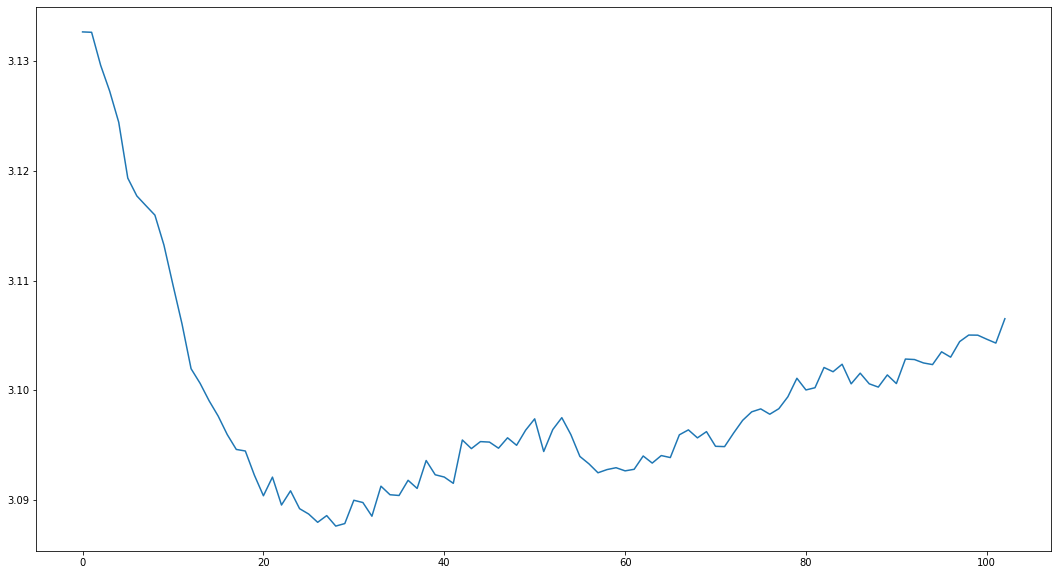

In [34]:
X = X.reshape(-1,5,5,103)
ENTROPY = np.zeros([42776,103])
for b in range(0,42776):  
  band_subset = X[b,:,:,:]
  n_row,n_column,n_band= band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
    band_i = hist[i].reshape(-1)/np.sum(hist[i])
    entr_i = entropy(band_i)
    ENTROPY[b][i] += entr_i  ## the entropy of one band of one batch
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-1

fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(121)
ax1.plot(np.average(ENTROPY,axis =0))

In [0]:
def BAM():
    model = Sequential()
    model.add(Conv2D(filters=64,
                     input_shape=(5, 5, 103),
                     kernel_size=(3,3),
                     strides=1,
                     padding='valid', name="Conv1"))
    model.add(ReLU(name="ReLU1"))
    model.add(GlobalAveragePooling2D(data_format="channels_first"))
    
    model.add(Dense(128))
    model.add(ReLU(name="ReLU2"))
    model.add(Dense(103, activation="sigmoid"))
  
    return model

In [0]:
def DCAE(weight_decay=0.0005):
    model = Sequential()
    model.add(Conv3D(filters=24,
                     input_shape=(103, 5, 5, 1),
                     kernel_size=(24, 3, 3),
                     strides=(1, 1, 1),
                     kernel_regularizer=regularizers.l2(l=weight_decay),
                     padding='valid', name="Conv1"))  
    model.add(BatchNormalization(name="BN1"))
    model.add(PReLU(name="PReLU1"))

    model.add(Conv3D(filters=48,
                     kernel_size=(24, 3, 3),  
                     strides=(1, 1, 1),
                     kernel_regularizer=regularizers.l2(l=weight_decay),
                     padding='valid', name="Conv2"))  
    model.add(BatchNormalization(name="BN2"))
    model.add(PReLU(name="PReLU2"))

    model.add(MaxPool3D(pool_size=(18, 1, 1),
                        strides=(18, 1, 1), name="Pool1"))

    model.add(Conv3DTranspose(filters=24,
                              kernel_size=(32, 3, 3), #(9,3,3),
                              kernel_regularizer=regularizers.l2(
                                  l=weight_decay),
                              strides=(22, 1, 1), name="Deconv1", padding='valid'))
    model.add(BatchNormalization(name="BN3"))
    model.add(PReLU(name="PReLU3"))
    model.add(Conv3DTranspose(filters=1,
                              kernel_size=(28, 3, 3),
                              kernel_regularizer=regularizers.l2(
                                  l=weight_decay),
                              strides=(1, 1, 1), name="Deconv2", padding='valid'))
    model.add(BatchNormalization(name="BN4"))
    
    return model

In [0]:
def Ensemble():
    input_layer = Input((5, 5, 103))
    band_activations = BAM()(input_layer)
    # band_activations = Reshape((200, 1, 1))(band_activations)
    
    bam_output = multiply([band_activations, input_layer])
    
    bam_output = Reshape((103, 5, 5, 1))(bam_output)
    # da_output = DA()(input_layer)
    # da_output = Permute((3,1,2), input_shape=(11,11,200))(da_output)
    # da_output = Reshape((200, 11, 11, 1))(da_output)
    output = DCAE()(bam_output)
    
    
    return Model(inputs=input_layer, outputs=output)
    

In [23]:
# model = DCAE(weight_decay=0.0005)
model = Ensemble()
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 5, 103)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 103)          73191       input_1[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 5, 5, 103)    0           sequential_1[1][0]               
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 103, 5, 5, 1) 0           multiply_1[0][0]       

In [0]:
def MeanSpectralDivergence(band_subset):

  n_row, n_column, n_band = band_subset.shape
  N = n_row * n_column
  hist = []
  for i in range(n_band):
    hist_, _ = np.histogram(band_subset[:, :, i], 256)
    hist.append(hist_ / N)
  hist = np.asarray(hist)
  hist[np.nonzero(hist <= 0)] = 1e-20
    # entropy_lst = entropy(hist.transpose())
  info_div = 0
    # band_subset[np.nonzero(band_subset <= 0)] = 1e-20
  for b_i in range(n_band):
    for b_j in range(n_band):
      band_i = hist[b_i].reshape(-1)/np.sum(hist[b_i])
      band_j = hist[b_j].reshape(-1)/np.sum(hist[b_j])
      entr_ij = entropy(band_i, band_j)
      entr_ji = entropy(band_j, band_i)
      entr_sum = entr_ij + entr_ji
      info_div += entr_sum
  msd = info_div * 2 / (n_band * (n_band - 1))
  return msd
def MSD2(x_predict,topbandindices):
  ##create band_subset
  x_predict = x_predict.reshape(42776,103,5,5)
  #print(x_predict.shape)                                        ## 42776,103,5,5
  band_subset_list = []
  for i in range(0,len(topbandindices)):
    band_subset_list.append(x_predict[:,i,:,:])     
  band_subset = np.array(band_subset_list)    
  #print(band_subset.shape)                                      ## band_subset.shape = ## 15,42776,5,5
  band_subset = np.stack(band_subset,axis = 1)     
  #print(band_subset.shape)                                      ## required shape is [42776,15,5,5] 
  band_subset = band_subset.reshape(42776,5,5,-1)
  #print(band_subset.shape)                
  xx = []
  for k in range(0,42776):
    xx.append(MeanSpectralDivergence(band_subset[k,:,:,:]))   
                                                                ## then reshape to [42776,5,5,15] 
  print(np.average(np.array(xx)))


In [0]:
ENTROPY = np.zeros(103)
import skimage.measure
def topkbands(x_predict, topk):
  for i in range(0,len(ENTROPY)):
    ENTROPY[i]+=entropy(np.unique(x_predict[:,i,:,:],return_counts=True)[1],base=2)
  
  
  return ENTROPY.argsort()[-topk:][::-1]

In [0]:
from keras.callbacks import Callback
from sklearn.metrics import mean_squared_error
import math

class MyLogger(Callback):
    def on_train_end(self,logs=None):
      x_predict = model.predict(X)
      bandlist = topkbands(x_predict, 15)
      with open('BANDLIST.txt', 'w') as filehandle:
        for banditem in bandlist:
          filehandle.write('%s\n' % banditem)  ## Manually download BANDLIST.txt from colab.
      MSD2(x_predict, bandlist)

In [32]:
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=0.1))

n_epoch = 50

model.fit(X, X.reshape(-1, 103, 5, 5, 1), epochs=n_epoch, shuffle=True, verbose=1, batch_size=256, callbacks=[MyLogger()])

Epoch 1/50
42776/42776 [==============================] - 8s 198us/step - loss: 7409.5062
Epoch 2/50
42776/42776 [==============================] - 7s 162us/step - loss: 5067.2307
Epoch 3/50
42776/42776 [==============================] - 7s 162us/step - loss: 4746.2936
Epoch 4/50
42776/42776 [==============================] - 7s 163us/step - loss: 4705.4500
Epoch 5/50
42776/42776 [==============================] - 7s 163us/step - loss: 4836.5524
Epoch 6/50
42776/42776 [==============================] - 7s 163us/step - loss: 4663.8184
Epoch 7/50
42776/42776 [==============================] - 7s 163us/step - loss: 5089.9840
Epoch 8/50
42776/42776 [==============================] - 7s 163us/step - loss: 4918.3206
Epoch 9/50
42776/42776 [==============================] - 7s 163us/step - loss: 5022.4874
Epoch 10/50
42776/42776 [==============================] - 7s 164us/step - loss: 4642.1993
Epoch 11/50
42776/42776 [==============================] - 7s 162us/step - loss: 4803.5030
Epoch 12